# Explore LSMC-Algorithm

In this Notebook we examine every step of the LSMC-Algorithm. It is used to play around with the algorithm itself and serves as a playground to create mock ups for the final code.



In [4]:
# Import Black Scholes Model
from LeastSquaresMonteCarlo import LSMC
# import necessary libraries
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial


# Estimate Delta by drifting the random path
def estimate_delta(Model, dS):

    price = Model.Price

    # Shift the path
    Model.randomWalk *= 1 + dS

    # pricing
    Model.pricing()

    Delta = (Model.Price - price) / (Model.spot_price * dS)

    print("")
    print("-----------------------------")
    print(f"Price of {Model.type} after {dS} shift: {Model.Price}")
    print(f"Stdandard deviation after {dS} shift: {Model.std}")
    print(f"Root Mean Sqaure Relative Error after {dS} shift: {Model.rmsre}")
    print(f"Estimated Delta of {Model.type}: {Delta}")
    print("-----------------------------")
    print("")

In [122]:

# Setup LSMC Model

type = "call"
spot = 5000
strike = 5000
time = 50 # time intervall
interest = 0.03 # percent
dividend = 0 # percent
volatility = 0.05 # percent
period = 50
simulations = 10000

Model = LSMC(
    type, spot, strike, time, interest, dividend, volatility, period, simulations
)

In [123]:
# Generate Price paths
Model.random_path()

# Payoff for each period of each paths
if Model.type == "p":
    Model.payoff = np.maximum(0, Model.strike_price - Model.randomWalk)
else:
    Model.payoff = np.maximum(0, Model.randomWalk - Model.strike_price) # For Technologyoption the strike price might rever to todays value und self.randWalk to possible NPVs with invest times in the future


Y = Model.randomWalk[:, -1]

for i in range(Model.period - 1, -1, -1): # before it was self.period - 2 why?

    # Calculate discount
    Y *= np.exp(Model.discount) # i think the payoff hast to be disounted
    # Find valid path
    hold = np.where(Model.payoff[:, i] > 0)[0]

    if len(hold) > Model.degree:
        #Y[hold] are the random price path from random walk where the the option is in the money

        # Apply Least square method
        #regression = np.polyfit(Model.randomWalk[hold, i], Y[hold], Model.degree)
        regression = Polynomial.fit(Model.randomWalk[hold, i], Y[hold], Model.degree)
        #CV = np.polyval(regression, Model.randomWalk[hold, i])
        CV = regression(Model.randomWalk[hold, i])

        # Whether to exercise now
        Y[hold] = np.where(
            Model.payoff[hold, i] > CV, Model.payoff[hold, i], Y[hold]
        )

        # mxing cashflow matrix with price of option
        # 
    

# Calculate mean and variance of the stimulation
Model.Price = np.mean(Y)
Model.std = np.std(Y) / np.sqrt(Model.path)
Model.rmsre = np.sqrt(np.mean(((Y - Model.Price) / Model.Price) ** 2))

print(Model.Price)

4962.295383296528


In [196]:
# Generate Price paths
Model.random_path()

# Payoff for each period of each paths
if Model.type == "p":
    Model.payoff = np.maximum(0, Model.strike_price - Model.randomWalk)
else:
    Model.payoff = np.maximum(0, Model.randomWalk - Model.strike_price) # For Technologyoption the strike price might rever to todays value und self.randWalk to possible NPVs with invest times in the future

Y = Model.payoff[:,-1] 

cash_flow_matrix = np.zeros_like(Model.payoff)

for i in range(Model.period - 2, -1, -1): # before it was self.period - 2 why? -> numpy index is excluding thus i=49 is the 50fth value, for regression we start with the 49fht vlaue that corresponds to index i=48 (or i=N_periods-2)
    
    # Find valid path where the are positive cashflow thus the option is in the money
    hold_mask = Model.payoff[:, i] > 0

    # Update current cashflows by discounted values from previous time step
    Y = Y * np.exp(Model.discount)
    
    if np.count_nonzero(hold_mask) > Model.degree: # keep sure that there is sufficent amount of point for the regression
        #Y[hold] are the random price path from random walk where the the option is in the money
    
        # Apply Least square method
        regression = Polynomial.fit(Model.randomWalk[hold_mask, i], Y[hold_mask], Model.degree)
        CV = regression(Model.randomWalk[hold_mask, i])

        # Whether to exercise now
        Y[hold_mask] = np.where(
            Model.payoff[hold_mask, i] > CV, Model.payoff[hold_mask, i], Y[hold_mask]
        )

        #Update cash flow matrix
        cash_flow_matrix[hold_mask,i] = Y[hold_mask]

#Discount cash flows of each price path to time zero
num_paths, num_time_steps = cash_flow_matrix.shape
discount_factors = np.array([1/(1 + Model.interest_rate) ** (t) for t in range(num_time_steps)])
discounted_cash_flows = cash_flow_matrix * discount_factors

# Sum the discounted cash flows along the time dimension to get the value at time zero
cash_flow_matrix[:,0] =  np.sum(discounted_cash_flows, axis=1)




# Calculate mean and variance of the stimulation
Model.Price = np.mean(cash_flow_matrix[:,0])
Model.std = np.std(cash_flow_matrix[:,0]) / np.sqrt(Model.path)
Model.rmsre = np.sqrt(np.mean(((cash_flow_matrix[:,0] - Model.Price) / Model.Price) ** 2))



188540.97183076487
188540.97183076487


3758.2684760348657
3983.6351483751


In [7]:
Model.payoff.nonzero()

(array([    9,     9,     9, ..., 99990, 99990, 99990], dtype=int64),
 array([45, 46, 47, ..., 46, 47, 49], dtype=int64))

In [8]:
Model.payoff[7,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [82]:
x = np.array([[3, 0, 0], [0, 4, 0], [5, 6, 0]])
x

array([[3, 0, 0],
       [0, 4, 0],
       [5, 6, 0]])

In [83]:
x.nonzero()

(array([0, 1, 2, 2], dtype=int64), array([0, 1, 0, 1], dtype=int64))

In [101]:
hold = np.where(x[:,1] > 0)[0]
hold

array([1, 2], dtype=int64)

In [106]:
hold = np.where(x > 0)[0]
hold_mask = x[:,1] > 0
hold_mask

array([False,  True,  True])

In [107]:
len(hold)

4

In [108]:
x[hold, 1]

array([0, 9, 9, 9])

In [109]:
x[hold_mask, 1]

array([9, 9])

In [110]:
x[hold_mask, 1] = 9
x

array([[3, 0, 0],
       [0, 9, 0],
       [5, 9, 0]])

In [111]:
np.count_nonzero(hold_mask)

2

In [112]:
hold_mask

array([False,  True,  True])

In [158]:
option = ((0.17+0.34+0.18+0.22)*(1/1.06)+0.07*(1.06**(-3)))/8
option

0.1146579894812496

In [154]:
option = (0.17+0.34+0.18+0.22)+0.07*(1.06**(-2))
option

0.9722997508009967

In [163]:
cash_flow_matrix

array([[    0.        ,     0.        ,     0.        , ...,
        14238.64053811,     0.        ,     0.        ],
       [    0.        ,  2136.93670773,  2202.01611925, ...,
         8752.79745618,     0.        ,     0.        ],
       [    0.        ,  6429.79401278,  6625.61039286, ...,
        26336.14953372,     0.        ,     0.        ],
       ...,
       [    0.        , 10153.1219756 , 10462.33057354, ...,
        41586.73482417,     0.        ,     0.        ],
       [    0.        ,  5672.74284562,  5845.50358522, ...,
        23235.30171441,     0.        ,     0.        ],
       [    0.        ,  6825.04890062,  7032.90258409, ...,
        27955.09592753,     0.        ,     0.        ]])

In [171]:
import numpy as np

def discount_cash_flows(cash_flow_matrix, discount_rate, time_step_zero=0):
    num_paths, num_time_steps = cash_flow_matrix.shape

    # Calculate discount factors for each time step
    discount_factors = np.array([1 / (1 + discount_rate) ** (t - time_step_zero) for t in range(num_time_steps)])

    # Discount cash flows for each price path
    discounted_cash_flows = cash_flow_matrix * discount_factors

    # Sum the discounted cash flows along the time dimension to get the value at time zero
    cash_flow_at_time_zero = np.sum(discounted_cash_flows, axis=1)

    return cash_flow_at_time_zero

# Example usage
# Assuming you have a cash flow matrix with 3 price paths and 5 time steps
cash_flow_matrix = np.array([[0, 50, 100, 0, 0],
                             [0, 0, 0, 200, 0],
                             [0, 300, 0, 0, 0]])

discount_rate = 0.05
time_step_zero = 0

cash_flow_at_time_zero = discount_cash_flows(cash_flow_matrix, discount_rate, time_step_zero)
print(cash_flow_at_time_zero)


[138.32199546 172.76751971 285.71428571]


In [170]:
300 * (1 / (1 + discount_rate) ** (1))

285.7142857142857

[[0 0 1 0 1]
 [0 0 1 1 1]
 [0 1 0 1 1]]


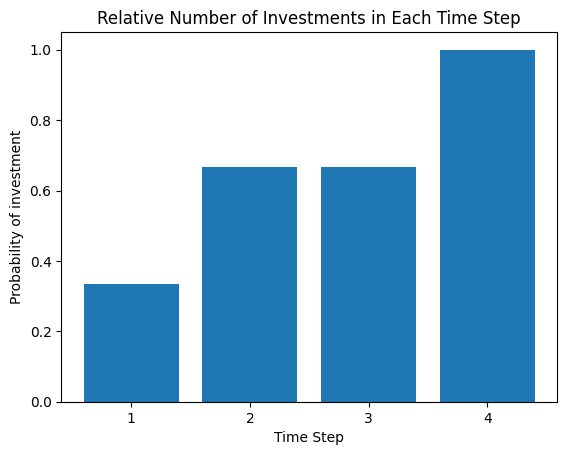

In [195]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def create_cashflow_indicator_matrix(cash_flow_matrix):
    # Create a new matrix with the same shape as the cash flow matrix, filled with zeros
    indicator_matrix = np.zeros_like(cash_flow_matrix)

    # Set the elements to 1 where the cash flow matrix has non-zero values
    indicator_matrix[cash_flow_matrix != 0] = 1

    return indicator_matrix

# Example usage
# Assuming you have a cash flow matrix with 3 price paths and 5 time steps
cash_flow_matrix = np.array([[0, 0, 100, 0, 567],
                             [0, 0, 100, 8, 567],
                             [0, 300, 0, 300, 567]])

cashflow_indicator_matrix = create_cashflow_indicator_matrix(cash_flow_matrix)
print(cashflow_indicator_matrix)


# Calculate the number of cash flows realized at each time step
cashflows_per_time_step = np.sum(cashflow_indicator_matrix, axis=0)
probability_of_invest = cashflows_per_time_step/cash_flow_matrix.shape[0]

# Generate time step labels (assuming you have 5 time steps)
time_step_labels = np.arange(1, probability_of_invest.shape[0])

# Plot the bar chart
plt.bar(time_step_labels, probability_of_invest[1:])
plt.xlabel('Time Step')
plt.ylabel('Probability of investment')
plt.title('Relative Number of Investments in Each Time Step')

# Set the x-axis ticks to show only integer values
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()